<h3>Batik image classification using CNN</h3>
<p>Author: HendryHB</p>

In [40]:
from google.colab import drive  # for google colab
import zipfile  # for google colab
import sys
import numpy as np
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras import layers, Model

from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import array_to_img

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [3]:
drive.mount('/content/drive')  # for google colab

In [4]:
with zipfile.ZipFile("/content/drive/MyDrive/raw_batik_v2.1.zip") as zip_ref:  # for colab
  zip_ref.extractall("./")

# Constants

In [41]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_CHANNELS = 3
BATCH_SIZE = 32

# Data Gathering

In [45]:
# Directory containing the data - fetching dataset from google drive

common_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='constant',
    rescale=1./255 
)

# Set up data generators for training, validation, and testing
train_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Set the target image size
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'  # For multi classes
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'
)


Found 640 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


# Data Exploration

## Train Dataset

#### `.n` is an attribute to the total count of images found and `.num_classes` is the number of subdirectories found (classes)

In [47]:
x_train_images = train_generator.n
y_train_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}, Number of classes:{train_generator.num_classes}")

Number of images: 640, Number of classes:20


In [44]:
x_train_all = []
y_train_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_train_images // BATCH_SIZE ):
    x_batch, y_batch = next(train_generator)
    x_train_all.append(x_batch)
    y_train_all.append(y_batch)

# Concatenate
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of x and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (640, 224, 224, 3)
y_train shape: (640, 20)


In [48]:
# Get class indices and create a reverse mapping
x_train_class_indices = train_generator.class_indices
y_train_index_to_class = {v: k for k, v in x_train_class_indices.items()}

In [51]:
# Define train labels that could be reused on later stage
train_labels = [y_train_index_to_class[idx] for idx in range(len(y_train_index_to_class))]
print("Class names:", train_labels)

Class names: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


In [50]:
val_num_images = validation_generator.n
val_num_classes = validation_generator.num_classes
print(f"Number of images: {validation_generator.n}")
print(f"Number of classes:{validation_generator.num_classes}")

NameError: name 'validation_generator' is not defined

In [13]:
class_indices = validation_generator.class_indices
y_val_class_names = {v: k for k, v in class_indices.items()}
print("Class names:", y_val_class_names)

Class names: {0: 'Aceh_Pintu_Aceh', 1: 'Bali_Barong', 2: 'Bali_Merak', 3: 'DKI_Ondel_Ondel', 4: 'JawaBarat_Megamendung', 5: 'JawaTimur_Pring', 6: 'Kalimantan_Dayak', 7: 'Lampung_Gajah', 8: 'Madura_Mataketeran', 9: 'Maluku_Pala', 10: 'NTB_Lumbung', 11: 'Papua_Asmat', 12: 'Papua_Cendrawasih', 13: 'Papua_Tifa', 14: 'Solo_Parang', 15: 'SulawesiSelatan_Lontara', 16: 'SumateraBarat_Rumah_Minang', 17: 'SumateraUtara_Boraspati', 18: 'Yogyakarta_Kawung', 19: 'Yogyakarta_Parang'}


In [14]:
num_classes = len(class_indices)
y_val_labels = [y_val_class_names[i] for i in range(num_classes)]
print(y_val_labels)

['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


In [15]:
x_val_all = []
y_val_all = []

# print(val_num_images)
# print(val_num_images // BATCH_SIZE + 1)

# Looping
for _ in range(val_num_images // BATCH_SIZE + 1):
    x_val_batch, y_val_batch = next(validation_generator)
    x_val_all.append(x_val_batch)
    y_val_all.append(y_val_batch)

# Concatenate
x_val = np.concatenate(x_val_all, axis=0)
y_val = np.concatenate(y_val_all, axis=0)

# Display the shapes of x and y_train
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (1020, 224, 224, 3)
y_val shape: (1020, 20)


In [16]:
no_images, x, y, c = x_val.shape
print(f"images = {no_images} \t| width = {x} \t| height = {y} \t| channels = {c} \t")

images = 1020 	| width = 224 	| height = 224 	| channels = 3 	


## Test Dataset

In [52]:
x_test_images = test_generator.n
y_test_classes = test_generator.num_classes
print(f"Number of images: {test_generator.n}, Number of classes:{test_generator.num_classes}")

Number of images: 160, Number of classes:20


In [53]:
x_test_all = []
y_test_all = []

# Looping, check: // BATCH_SIZE or + 1
for _ in range(x_test_images // BATCH_SIZE):
    x_test_batch, y_test_batch = next(test_generator)
    x_test_all.append(x_test_batch)
    y_test_all.append(y_test_batch)

# Concatenate
x_test = np.concatenate(x_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Display the shapes of x and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (160, 224, 224, 3)
y_test shape: (160, 20)


In [54]:
# Get class indices and create a reverse mapping
x_test_class_indices = test_generator.class_indices
y_test_index_to_class = {v: k for k, v in x_test_class_indices.items()}

In [55]:
# Define test labels that could be reused on later stage
test_labels = [y_test_index_to_class[idx] for idx in range(len(y_test_index_to_class))]
print("Class names:", test_labels)

Class names: ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']


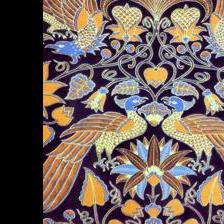

In [19]:
pic = array_to_img(x_train[7])
display(pic)

In [20]:
# LABEL_NAMES[y_train[7]]  # used only if only non scalar index
LABEL_NAMES[np.argmax(y_train[7])]

'Bali Merak'

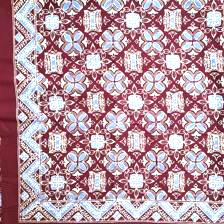

In [21]:
pic = array_to_img(x_val[27])
display(pic)

In [22]:
# LABEL_NAMES[y_val[27]]
LABEL_NAMES[np.argmax(y_val[27])]

'Aceh PintuAceh'

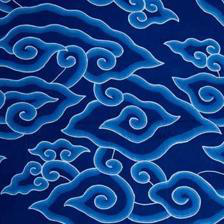

In [23]:
pic = array_to_img(x_test[99])
display(pic)

In [24]:
# LABEL_NAMES[y_test[99]]
LABEL_NAMES[np.argmax(y_test[99])]

'JawaBarat Megamendung'

In [194]:
print(type(x_train))
print(type(x_val))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Preprocessing MUST BE RUN for transfer learning

In [22]:
x_train_preprocessed = preprocess_input(x_train)

In [23]:
print("x_train shape (preprocessed):", x_train_preprocessed.shape)
print("x_train shape (preprocessed):", x_train_preprocessed[0, 0, 0, :])
print("y_train shape:", y_train.shape)

x_train shape (preprocessed): (4100, 224, 224, 3)
x_train shape (preprocessed): [-103.939 -116.779 -123.68 ]
y_train shape: (4100, 20)


In [33]:
x_train_test = np.random.rand(4100, 224, 224, 3)
x_train_preprocessed_test = preprocess_input(x_train_test)
print("Shape of x_train_preprocessed: ", x_train_preprocessed_test.shape)
print("Minimum value of x_train_preprocessed: ", np.min(x_train_preprocessed_test))
print("Maximum value of x_train_preprocessed: ", np.max(x_train_preprocessed_test))

Shape of x_train_preprocessed:  (4100, 224, 224, 3)
Minimum value of x_train_preprocessed:  -123.67999999910161
Maximum value of x_train_preprocessed:  -102.93900000054862


In [24]:
x_val_preprocessed = preprocess_input(x_val)
print("x_val shape (preprocessed):", x_val_preprocessed.shape)
print("y_val shape:", y_val.shape)

x_val shape (preprocessed): (1020, 224, 224, 3)
y_val shape: (1020, 20)


In [25]:
x_test_preprocessed = preprocess_input(x_test)
print("x_test shape (preprocessed):", x_test_preprocessed.shape)
print("y_test shape:", y_test.shape)

x_test shape (preprocessed): (1280, 224, 224, 3)
y_test shape: (1280, 20)


### Check dtype

### Train

In [190]:
x_train[0][0][0]

array([0., 0., 0.], dtype=float32)

In [193]:
x_train[0][0]

array([[  0.,   0.,   0.],
       [  0.,   0.,   0.],
       [ 11.,  11.,  11.],
       [ 57.,  57.,  57.],
       [142., 142., 142.],
       [164., 164., 164.],
       [ 23.,  23.,  23.],
       [119., 119., 119.],
       [ 53.,  53.,  53.],
       [ 52.,  52.,  52.],
       [  7.,   7.,   7.],
       [ 16.,  16.,  16.],
       [ 10.,  10.,  10.],
       [  2.,   2.,   2.],
       [ 13.,  13.,  13.],
       [ 34.,  34.,  34.],
       [  3.,   3.,   3.],
       [  3.,   3.,   3.],
       [  1.,   1.,   1.],
       [  4.,   4.,   4.],
       [ 11.,  11.,  11.],
       [ 39.,  39.,  39.],
       [ 44.,  44.,  44.],
       [  1.,   1.,   1.],
       [  4.,   4.,   4.],
       [ 13.,  13.,  13.],
       [  5.,   5.,   5.],
       [  0.,   0.,   0.],
       [ 44.,  44.,  44.],
       [  1.,   1.,   1.],
       [ 98.,  98.,  98.],
       [ 92.,  92.,  92.],
       [  8.,   8.,   8.],
       [141., 141., 141.],
       [ 62.,  62.,  62.],
       [ 30.,  30.,  30.],
       [  0.,   0.,   0.],
 

In [ ]:
x_train[0][0][0][0]

139.0

In [ ]:
x_val[0][0][0]

array([ 27.,  36., 103.], dtype=float32)

In [ ]:
x_test[0][0][0]

array([85., 28., 35.], dtype=float32)

In [26]:
x_train_normalized, x_validation_normalized, x_test_normalized = x_train_preprocessed / 255.0, x_val_preprocessed /255.0, x_test_preprocessed / 255.0

In [26]:
# x_train_normalized, x_validation_normalized, x_test_normalized = x_train_preprocessed, x_val_preprocessed, x_test_preprocessed

In [27]:
print(type(x_train_normalized))
print(type(x_validation_normalized))
print(type(x_test_normalized))
print(x_train_normalized.shape)
print(x_validation_normalized.shape)
print(x_test_normalized.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(4100, 224, 224, 3)
(1020, 224, 224, 3)
(1280, 224, 224, 3)


In [38]:
# x_train_normalized[0] 

In [31]:
x_train_normalized[0][0][0]

array([0., 0., 0.], dtype=float32)

In [32]:
x_validation_normalized[0][0][0]

array([0.00033833, 0.0002922 , 0.00046136], dtype=float32)

In [27]:
x_test_normalized[0][0][0]

array([0.03529412, 0.03529412, 0.03529412], dtype=float32)

In [24]:
# Needs to be float64 or float32
print(type(x_train_normalized[0][0][0][0]))
print(type(x_validation_normalized[0][0][0][0]))
print(type(x_test_normalized[0][0][0][0]))

<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


In [25]:
print(x_train_normalized.shape[0])
print(x_validation_normalized.shape[0])
print(x_test_normalized.shape[0])

4100
1020
1280


## x_train Before Reshaping

In [36]:
# x_train_normalized.shape

(4100, 224, 224, 3)

## Reshaping

In [30]:
# Reshaping to preserve the spatial structure and image dimensions and color
# x_train_normalized = x_train_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)

Only Run this when needs to make single dimension

In [29]:
# Reshaping to flatten spatial dimensions and color into single dimension
# x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], TOTAL_INPUTS)

In [38]:
# x_train_normalized.shape

(4100, 224, 224, 3)

In [ ]:
# 224 * 224 * 3

150528

## x_validation Before Reshaping

In [203]:
# x_validation_normalized.shape

(1020, 224, 224, 3)

## Reshaping

In [31]:
# Reshaping to preserve the spatial structure and image dimensions and color
# x_validation_normalized = x_validation_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)

Only Run this when needs to make single dimension

In [31]:
# Reshaping to flatten spatial dimensions and color into single dimension
# x_validation_normalized = x_validation_normalized.reshape(x_validation_normalized.shape[0], TOTAL_INPUTS)

In [23]:
# x_validation_normalized.shape

(1020, 224, 224, 3)

## x_test Before Reshaping

In [152]:
# x_test_normalized.shape

(1280, 150528)

## Reshaping

In [32]:
# Reshaping to preserve the spatial structure and image dimensions and color
# x_test_normalized = x_test_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)

Only Run this when needs to make single dimension

In [33]:
# Reshaping to flatten spatial dimensions and color into single dimension
# x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], TOTAL_INPUTS)

In [25]:
x_test_normalized.shape

(1280, 224, 224, 3)

### RUN only run this Converting dtype to uint8 when it is needed to convert

In [ ]:
x_train = x_train.astype('uint8')

In [ ]:
type(x_train[0])

numpy.ndarray

In [ ]:
type(x_train[0][0][0][0])

numpy.uint8

In [ ]:
x_val = x_val.astype('uint8')

In [ ]:
type(x_val[0])

numpy.ndarray

In [ ]:
type(x_val[0][0][0][0])

numpy.uint8

In [ ]:
x_test = x_test.astype('uint8')

In [ ]:
type(x_test[0])

numpy.ndarray

In [ ]:
type(x_test[0][0][0][0])

numpy.uint8



```
# This is formatted as code
```

### RUN Only this when its needed to convert to x_train to float32 -

### Train

In [ ]:
# To convert x_train to float32
x_train = x_train.astype('float32')
x_train[0][0][0]

array([0., 0., 0.], dtype=float32)

In [ ]:
x_train = x_train.astype('float32')
x_train[0][0][0][0]

0.0

In [ ]:
type(x_train[0][0][0][0])

numpy.float32

### Validation

In [ ]:
# To convert x_train to float32
x_validation = x_validation.astype('float32')
x_validation[0][0][0]

array([103.,  64.,  49.], dtype=float32)

In [ ]:
x_validation = x_validation.astype('float32')
x_validation[0][0][0][0]

103.0

In [ ]:
type(x_validation[0][0][0][0])

numpy.float32

### Test

In [ ]:
# To convert x_train to float32
x_test = x_test.astype('float32')
x_test[0][0][0]

array([ 58., 189., 173.], dtype=float32)

In [ ]:
x_test = x_test.astype('float32')
x_test[0][0][0][0]

58.0

# Plotting Images

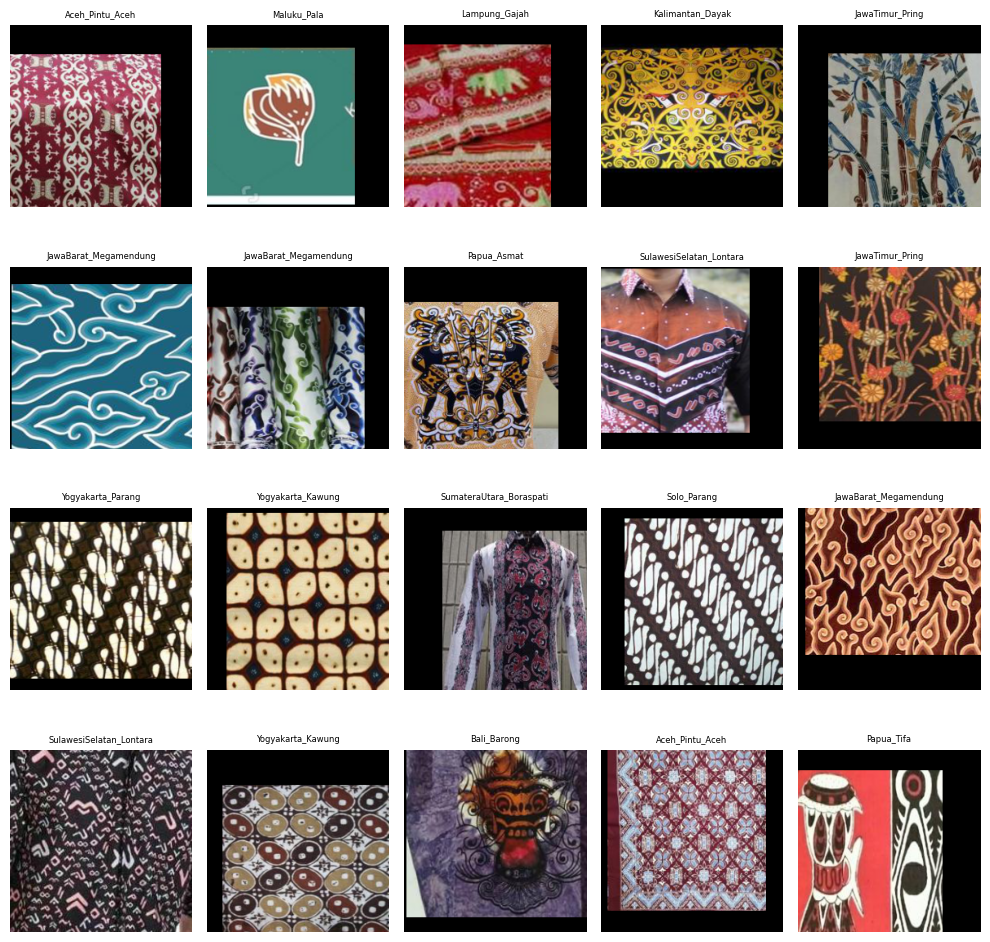

In [19]:
# Fetch a batch of images and labels from the generator
x_train_images, y_train_labels = next(train_generator)

# Shuffle the images and labels
shuffle_indices = np.random.permutation(x_train_images.shape[0])
x_train_images = x_train_images[shuffle_indices]
y_train_labels = y_train_labels[shuffle_indices]

# Get class names from the train labels using the train_labels list
class_names = [train_labels[np.argmax(label)] for label in y_train_labels]

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
axes = axes.ravel()

# Plot images with their corresponding class names
for i in range(20):
    axes[i].imshow(x_train_images[i])
    axes[i].set_title(class_names[i], fontsize=6)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

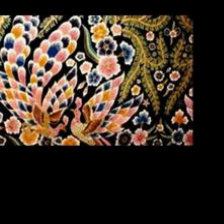

In [14]:
pic = array_to_img(x_train[7])
display(pic)

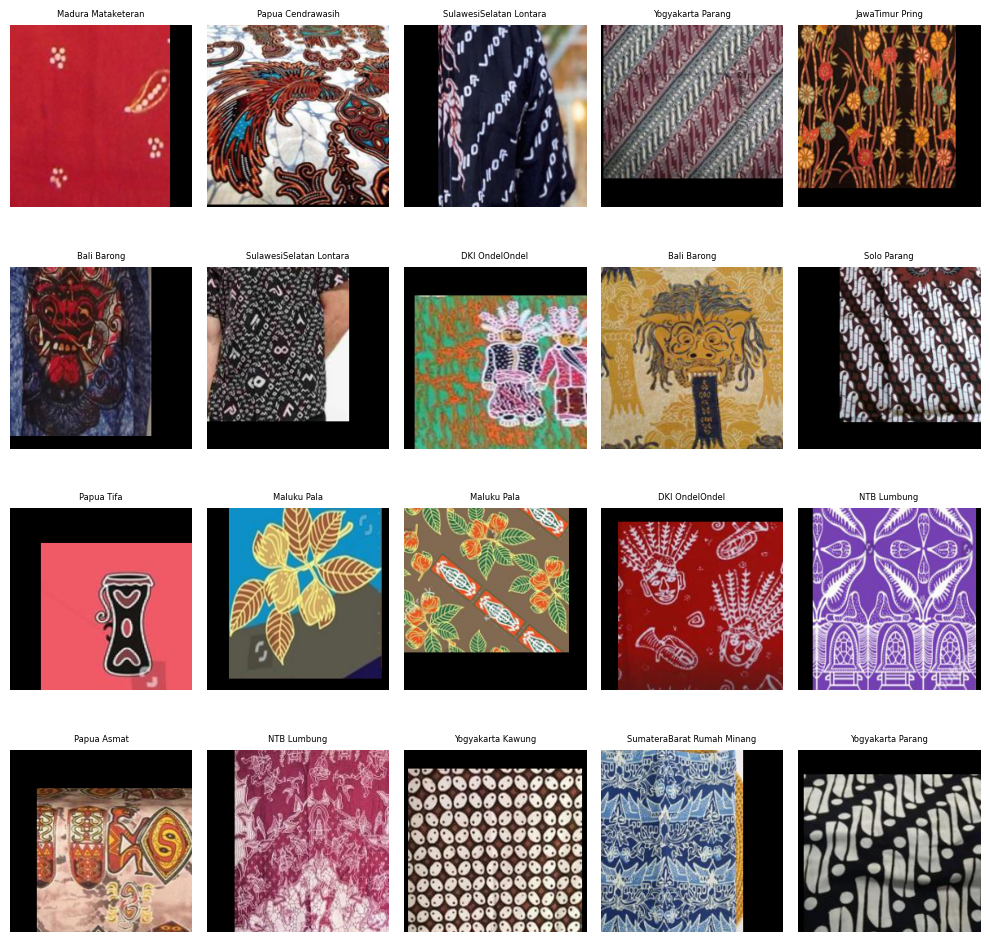

In [17]:
# Fetch random images and corresponding labels directly not from generator
random_images = x_train
train_labels = y_train

shuffle_indices = np.random.permutation(random_images.shape[0])
random_images = random_images[shuffle_indices]
train_labels = train_labels[shuffle_indices]


# If Get class names from the dictionary mapping class indices to class names
# class_names = [y_train_class_names[np.argmax(label)] for label in train_labels]

# To Get class names from LABEL_NAMES using the labels
class_names = [LABEL_NAMES[np.argmax(label)] for label in train_labels]


fig, axes = plt.subplots(4, 5, figsize=(10, 10))
axes = axes.ravel()

# Fetch
for i in range(20):
  axes[i].imshow(random_images[i])
  # axes[i].set_title(class_names[np.argmax(train_labels[i])], fontsize=6) # only use when using argmax
  # axes[i].set_title(class_names[train_labels[i]], fontsize=6)
  axes[i].set_title(class_names[i], fontsize=6)
  axes[i].axis('off')

plt.tight_layout()
plt.show()


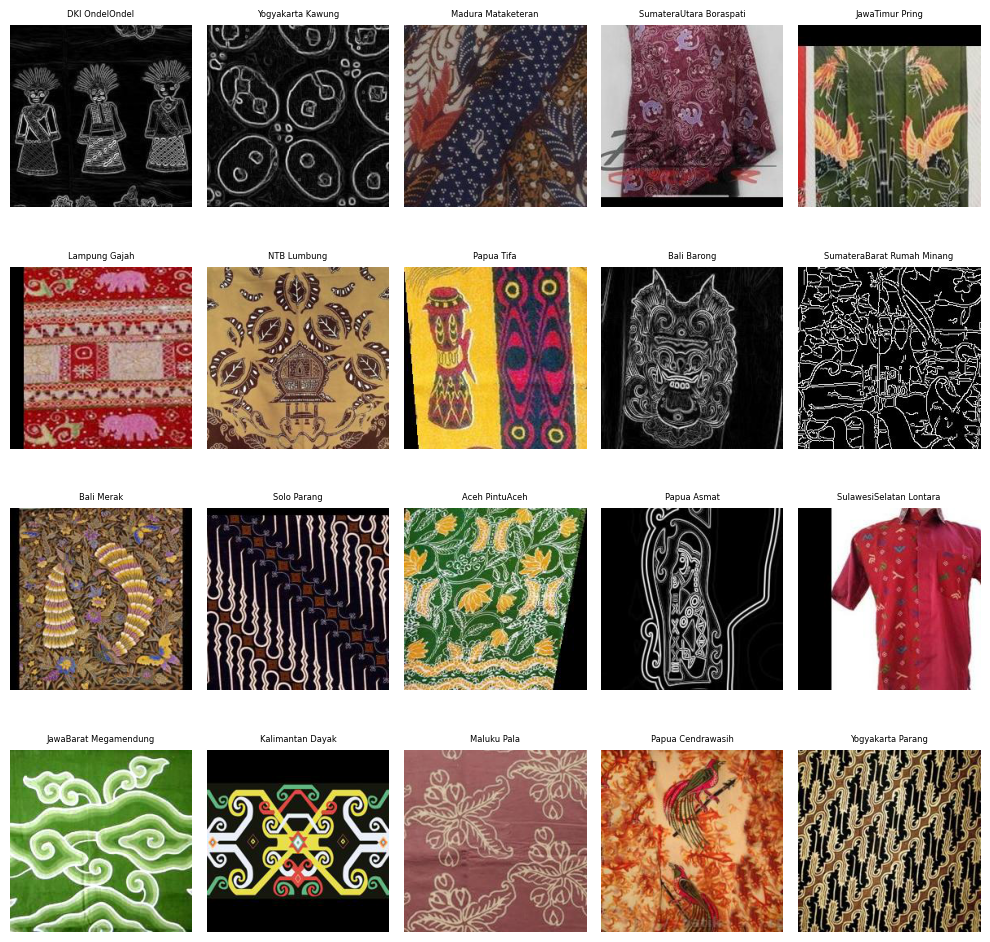

In [166]:
# FETCHING 1 IMAGE PER CLASS

# Fetch random images and corresponding labels from Train Generator
random_images = x_train_normalized
train_labels = y_train

# Initialize a dictionary to keep track of selected classes
selected_classes = {}

# Shuffle the images and labels
shuffle_indices = np.random.permutation(random_images.shape[0])
random_images = random_images[shuffle_indices]
train_labels = train_labels[shuffle_indices]

# Iterate over the shuffled data to select one image per class
selected_images = []
selected_labels = []
for i in range(random_images.shape[0]):
    label_index = np.argmax(train_labels[i])
    if label_index not in selected_classes:
        # Add the image and label to the selected data
        selected_images.append(random_images[i])
        selected_labels.append(train_labels[i])
        # Mark the class as selected
        selected_classes[label_index] = True

    # If one image per class has been selected, break the loop
    if len(selected_images) == len(LABEL_NAMES):
        break

# Convert the selected images and labels to numpy arrays
selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

# If to get class names from the dictionary mapping class indices to class names (or from folder)
# class_names = [y_train_class_names[np.argmax(label)] for label in train_labels]

# Get class names from LABEL_NAMES using the labels
class_names = [LABEL_NAMES[np.argmax(label)] for label in selected_labels]

# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
axes = axes.ravel()

# Plot each image with its corresponding class name
for i in range(selected_images.shape[0]):
    axes[i].imshow(selected_images[i])
    # axes[i].set_title(class_names[np.argmax(train_labels[i])], fontsize=6) # only use when using argmax
    # axes[i].set_title(class_names[train_labels[i]], fontsize=6)
    axes[i].set_title(class_names[i], fontsize=6)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Assuming y_train and y_val are one-hot encoded, convert them to integer indices - ONLY run this if it is needed

In [ ]:
y_train_indices = np.argmax(y_train_normalized, axis=1)
y_val_indices = np.argmax(y_validation_normalized, axis=1)
y_test_indices = np.argmax(y_test_normalized, axis=1)

## ONLY RUN this if Images need to put back to original sizes in tuple

In [ ]:
original_image_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS)

x_train_original_shape = x_train.reshape(x_train.shape[0], *original_image_shape)
x_val_original_shape = x_validation.reshape(len(x_validation), *original_image_shape)
x_test_original_shape = x_test.reshape(len(x_test), *original_image_shape)
print(x_train_original_shape.shape)
print("Shape of x_train_original_shape:", x_train_original_shape.shape)

# Assuming the needs to reshape it back to get (None, IMAGE_HEIGHT, IMAGE_WIDTH,COLOR_CHANNELS)
x_train_normalized = x_train_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)
x_validation_normalized = x_validation_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)
x_test_normalized = x_test_normalized.reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)

(520, 224, 224, 3)
Shape of x_train_original_shape: (520, 224, 224, 3)


In [42]:
26*8*20

4160

# Modelling

## Self-Defined CNN

In [20]:
# Set the global random seed
tf.random.set_seed(42)
input_layer = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS))

# block 1
conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                               activation='relu', padding='same')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = tf.keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = tf.keras.layers.Dropout(rate=0.2)(norm1)

# block 2
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = tf.keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = tf.keras.layers.Dropout(rate=0.2)(norm2)

# block 3
conv3 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
norm3 = tf.keras.layers.BatchNormalization(axis = -1)(pool3)
drop3 = tf.keras.layers.Dropout(rate=0.2)(norm3)

# block 4
conv4 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)
norm4 = tf.keras.layers.BatchNormalization(axis = -1)(pool4)
drop4 = tf.keras.layers.Dropout(rate=0.2)(norm4)

# block 5
conv5 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3),
                               activation='relu', padding='same')(drop4)
pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)
norm5 = tf.keras.layers.BatchNormalization(axis = -1)(pool5)
drop5 = tf.keras.layers.Dropout(rate=0.2)(norm5)

flat = tf.keras.layers.Flatten()(drop5)  #Flatten the matrix to get it ready for dense:).

# Dense Layers
hidden1 = tf.keras.layers.Dense(64, activation='relu')(flat)
norm6 = tf.keras.layers.BatchNormalization(axis = -1)(hidden1)
drop6 = tf.keras.layers.Dropout(rate=0.2)(norm6)

output_layer = tf.keras.layers.Dense(20, activation='softmax')(drop6)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496 

In [39]:
type(model)

keras.src.engine.functional.Functional

# Compile

In [25]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Training - Fit Model

In [37]:
class SaveHistoryCallback(Callback):
    # def __init__(self, model_name):  # with model_name
    def __init__(self):    # without model_name
        super(SaveHistoryCallback, self).__init__()
        # self.base_path = '/Users/hendrysi/Data_w/Dev/py/machine_learning/batik/vgg'  # Define the base path here - JNB
        self.base_path = '/Users/monsky/colab'
        # self.base_path = '/content/saved_models/'  # Define the base path here - COLAB
        # self.model_name = aug_cnn_model1  # Could be omitted if not needed

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        # file_path = os.path.join(self.base_path, f'{self.model_name}_history.json')  # if using model name
        file_path = os.path.join(self.base_path, 'aug_vgg16_model4_2_history1_retest1.json')
        with open(file_path, 'a') as file:
            json.dump(logs, file)
            file.write('\n')

In [26]:
%%time
EPOCHS = 150
                                  
# Define EarlyStop
early_stop = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=100, min_lr=1e-6)

# Define callbacks
callbacks = [early_stop, reduce_lr]

# Train the model
history = model.fit(train_generator,
                               verbose=1,
                               epochs=EPOCHS,
                               callbacks=callbacks,
                               validation_data=(test_generator))

## Plotting Accuracy and Loss Graphs 

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot accuracy
plt.plot(epochs, acc, 'g')
plt.plot(epochs, val_acc, 'orange')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

# Plot loss
plt.plot(epochs, loss, 'g')
plt.plot(epochs, val_loss, 'orange')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

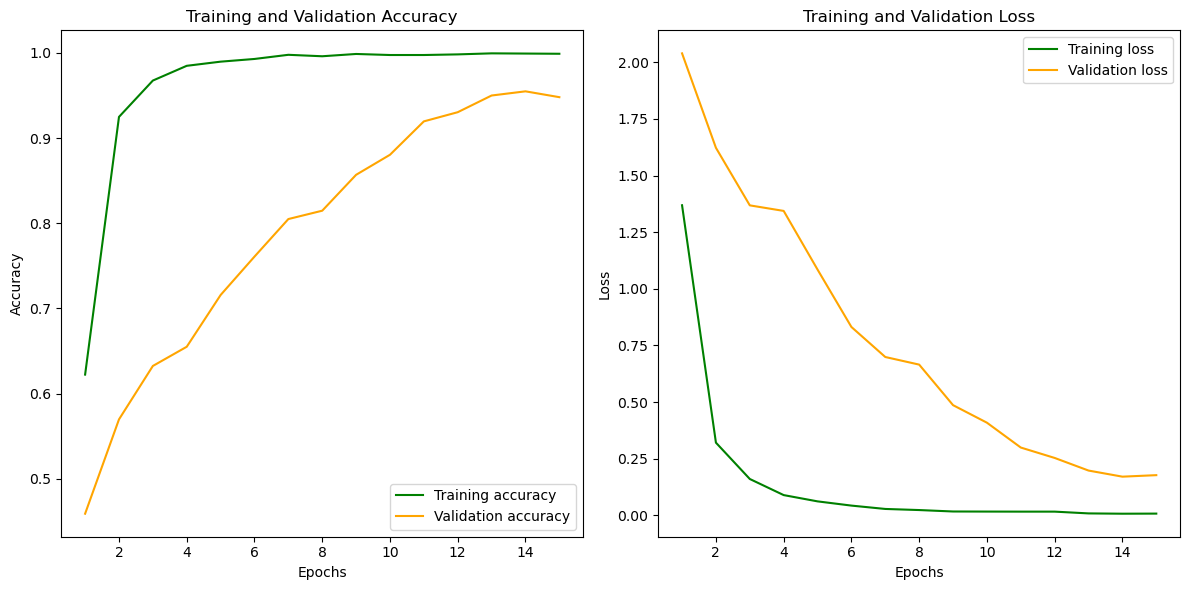

In [43]:
# Load the training history data from the JSON files
# history_file1 = '/content/saved_models/aug_cnn_history1.json'  # COLAB
history_file1 = '/Users/hendrysi/Data_w/Dev/py/machine_learning/batik/aug_mobilenetv2_model_1history1.json'  # Jupyter NB

def load_history_data(file_path):
    with open(file_path, 'r') as file:
        history_data = [json.loads(line) for line in file]
    return history_data

history_data1 = load_history_data(history_file1)
# print(history_data1)

# Extract metrics data from the first training session
acc_1 = [epoch['accuracy'] for epoch in history_data1]
val_acc_1 = [epoch['val_accuracy'] for epoch in history_data1]
loss_1 = [epoch['loss'] for epoch in history_data1]
val_loss_1 = [epoch['val_loss'] for epoch in history_data1]
epochs_1 = range(1, len(acc_1) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# To plot side-by-side graph
# Plot accuracy
axs[0].plot(epochs_1, acc_1, 'g', label='Training accuracy')
axs[0].plot(epochs_1, val_acc_1, 'orange', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs_1, loss_1, 'g', label='Training loss')
axs[1].plot(epochs_1, val_loss_1, 'orange', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# # To plot top down graph
# # Plot accuracy
# plt.plot(epochs_1, acc_1, 'b', label='Training accuracy')
# plt.plot(epochs_1, val_acc_1, 'g', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot loss
# plt.plot(epochs_1, loss_1, 'b', label='Training loss')
# plt.plot(epochs_1, val_loss_1, 'r', label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Evaluation and Prediction

In [28]:
np.set_printoptions(precision=3)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss : {test_loss:0.3} and the test accuracy: {test_accuracy:0.2%}")

5/5 [==============================] - 18s 3s/step - loss: 1.9566 - accuracy: 0.7063
Test loss : 1.96 and the test accuracy: 70.63%


In [29]:
predictions = model.predict(test_generator)
y_test_labels = np.argmax(y_test, axis=1)

5/5 [==============================] - 17s 3s/step


In [33]:
y_pred = predictions.argmax(axis=1)
classify_report = classification_report(y_test_labels, y_pred, target_names=test_labels)
print(classify_report)

                            precision    recall  f1-score   support

           Aceh_Pintu_Aceh       0.00      0.00      0.00         8
               Bali_Barong       0.12      0.12      0.12         8
                Bali_Merak       0.22      0.25      0.24         8
           DKI_Ondel_Ondel       0.00      0.00      0.00         8
     JawaBarat_Megamendung       0.17      0.12      0.14         8
           JawaTimur_Pring       0.00      0.00      0.00         8
          Kalimantan_Dayak       0.00      0.00      0.00         8
             Lampung_Gajah       0.08      0.12      0.10         8
        Madura_Mataketeran       0.00      0.00      0.00         8
               Maluku_Pala       0.00      0.00      0.00         8
               NTB_Lumbung       0.00      0.00      0.00         8
               Papua_Asmat       0.00      0.00      0.00         8
         Papua_Cendrawasih       0.00      0.00      0.00         8
                Papua_Tifa       0.00      0.00

<h3>Feel Free to Fine-tune</h3>
<p>By fine-tuning the model, there is a chance that the accuracy performance will improve, and not only accuracy but also the training and validation loss curves will converge. It is recommended to explore and perform this adjustment. Indeed, there is a need to perform dataset augmentation for all. Below are the images from the fine-tuned models that generate better classification reports.</p>
<img src="https://github.com/hendryhb/kecakbali/blob/main/classy_report.png?raw=true">